In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import tensorflow as tf

2025-05-30 18:39:37.754397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_df = pd.read_csv("titanic/train.csv")
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def preprocess(df):
    df = df.copy()

    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])

    def ticket_number(x):
        return x.split(" ")[-1]

    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])

    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    return df

preprocessed_train_df = preprocess(train_df)
#preprocessed_serving_df = preprocess(serving_df)

preprocessed_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


In [4]:
# Remove features we don't want to use
# PassengerId is self defined
# Ticket is split into two features
# Survived is the output
input_features = list(preprocessed_train_df.columns)
unwanted_features = ['Ticket', 'PassengerId', 'Survived']

for feature in unwanted_features:
    input_features.remove(feature)

print(f"Input features: {input_features}")

Input features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Ticket_number', 'Ticket_item']


In [5]:
# Split into X and y for input and output
X = preprocessed_train_df[input_features]
y = preprocessed_train_df['Survived']
print(X.head(5))
print(y.head(5))

   Pclass                                             Name     Sex   Age  \
0       3                            Braund Mr Owen Harris    male  22.0   
1       1  Cumings Mrs John Bradley Florence Briggs Thayer  female  38.0   
2       3                             Heikkinen Miss Laina  female  26.0   
3       1         Futrelle Mrs Jacques Heath Lily May Peel  female  35.0   
4       3                           Allen Mr William Henry    male  35.0   

   SibSp  Parch     Fare Cabin Embarked Ticket_number Ticket_item  
0      1      0   7.2500   NaN        S         21171         A/5  
1      1      0  71.2833   C85        C         17599          PC  
2      0      0   7.9250   NaN        S       3101282    STON/O2.  
3      1      0  53.1000  C123        S        113803        NONE  
4      0      0   8.0500   NaN        S        373450        NONE  
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


In [6]:
# Split into numerical and categorical features so we can infer missing values
numerical_features = ['Pclass', 'Age', 'Fare', 'Ticket_number']
categorical_features = ['Name', 'SibSp', 'Parch', 'Sex', 'Embarked', 'Ticket_item']

# Use preprocessing pipelines to guess missing values with the median or mode values (numerical or categorical)
# For numerical features: Impute missing values with median, then scale
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For categorical features: Impute missing values with most frequent, then one-hot encode
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # drop='first' to avoid multicollinearity
])

# Create a ColumnTransformer to apply different transformations to different columns
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
], remainder='passthrough') # 'passthrough' keeps columns not specified (e.g. Pclass, SibSp, Parch if not in num/cat explicitly)

# If Pclass, SibSp, Parch are not in numerical_features and not in categorical_features,
# and we want them scaled, they should be in numerical_features.
# Let's adjust:
numerical_features_adjusted = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch'] # Pclass, SibSp, Parch are numerical
categorical_features_adjusted = ['Sex', 'Embarked']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features_adjusted),
        ('cat', categorical_pipeline, categorical_features_adjusted)
    ],
    remainder='drop' # Drop any columns not specified
)

In [7]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training set shape: X_train: (712, 11), y_train: (712,)
Test set shape: X_test: (179, 11), y_test: (179,)


In [8]:
# Create the logistic regression model
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42)) # liblinear is good for smaller datasets
])

In [9]:
# Train the model
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare', 'Pclass',
                                                   'SibSp', 'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Sex', 'Embarked'])])),
                ('classifier',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [31]:
# Predict the outcomes on the test data
y_pred_train = logreg_pipeline.predict(X_train)
y_pred_test = logreg_pipeline.predict(X_test)
y_pred_proba_test = logreg_pipeline.predict_proba(X_test)[:, 1] # Probabilities for ROC curve

In [32]:
# Evaluate Model
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.8062
Test Accuracy: 0.8101


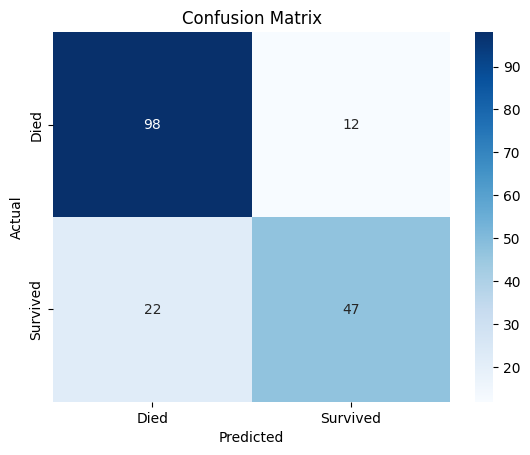

In [33]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
# print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Classification Report for Test Set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, target_names=['Died (0)', 'Survived (1)']))


Classification Report (Test Set):
              precision    recall  f1-score   support

    Died (0)       0.82      0.89      0.85       110
Survived (1)       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179




ROC AUC Score (Test Set): 0.8430


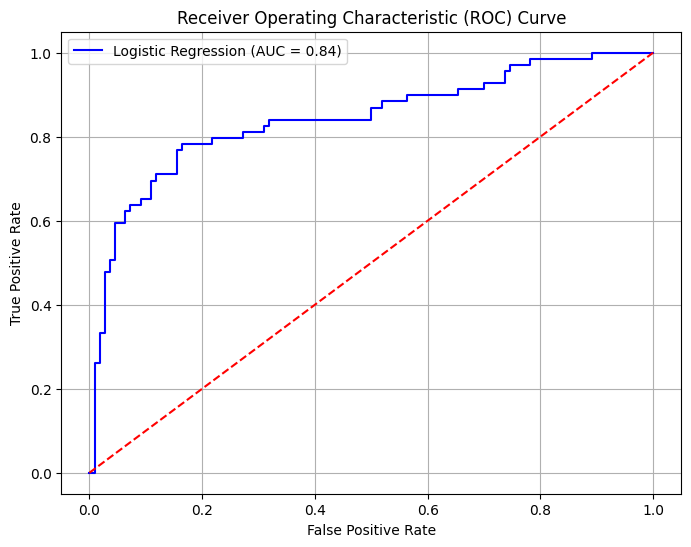

In [35]:
# ROC AUC Score for Test Set
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\nROC AUC Score (Test Set): {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# --- 7. Interpret Coefficients (Optional) ---
# To get coefficients, we need to access them from the 'classifier' step in the pipeline
# and know the feature names after transformation.

# Get feature names after one-hot encoding (from the preprocessor)
# This part can be a bit tricky with ColumnTransformer
try:
    onehot_feature_names = list(logreg_pipeline.named_steps['preprocessor']
                                .named_transformers_['cat']
                                .named_steps['onehot']
                                .get_feature_names_out(categorical_features_adjusted))
    
    # Combine with numerical feature names (which remain in order)
    # Note: Pclass, SibSp, Parch are scaled along with Age, Fare
    all_feature_names = numerical_features_adjusted + onehot_feature_names
    
    coefficients = logreg_pipeline.named_steps['classifier'].coef_[0]
    
    coef_df = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    print("\n--- Model Coefficients (Influence on Log-Odds of Survival) ---")
    print(coef_df)
    
    # Interpretation:
    # - Positive coefficient: an increase in this feature increases the log-odds (and thus probability) of survival.
    # - Negative coefficient: an increase in this feature decreases the log-odds of survival.
    # - The magnitude indicates the strength of the influence.
    # - For one-hot encoded features, it's relative to the dropped category (e.g., if 'Sex_male' is dropped, 'Sex_female' coefficient is wrt males).
    #   Here, we used drop='first', so if Sex has 'female', 'male', and 'female' comes first alphabetically, it's dropped.
    #   If 'male' is then 'Sex_male', its coefficient is the change in log-odds for males compared to females.
    #   It's important to check which category was dropped. Let's assume 'Sex_female' was dropped.
    #   pd.get_dummies(df['Sex'], drop_first=True) would create 'Sex_male'. A positive coef for 'Sex_male' would mean males are more likely to survive (incorrect for Titanic).
    #   Typically, Sex_female has a positive coefficient, meaning females more likely to survive.
    #   Let's quickly check the categories for Sex and Embarked to be sure:
    print("\nUnique values for Sex:", preprocessed_train_df['Sex'].unique()) # e.g. ['male' 'female']
    print("Unique values for Embarked:", preprocessed_train_df['Embarked'].unique()) # e.g. ['S' 'C' 'Q' nan]

    # If OneHotEncoder processes ['male', 'female'] and drop='first', 'female' is dropped (alphabetical).
    # So the remaining column would be for 'male'. A negative coefficient for 'Sex_male' would mean males are less likely to survive.

except Exception as e:
    print(f"\nCould not retrieve feature names for coefficients due to: {e}")
    print("This can happen with complex preprocessing pipelines. Manual inspection might be needed.")


--- Model Coefficients (Influence on Log-Odds of Survival) ---
      Feature  Coefficient
6  Embarked_Q     0.348117
1        Fare     0.105935
4       Parch    -0.055677
3       SibSp    -0.258158
7  Embarked_S    -0.328726
0         Age    -0.501511
2      Pclass    -0.917257
5    Sex_male    -2.528769

Unique values for Sex: ['male' 'female']
Unique values for Embarked: ['S' 'C' 'Q' nan]
